In [ ]:
import xarray as xr
import numpy as np
from scipy.ndimage import zoom as scipy_zoom
import os
import random
import netCDF4 as nc


# Define the data folder
folder_path = r'c:\Users\userAdmin\Desktop\Rain data files\IMERG 10yrs\data files'

# List all NetCDF files in the folder
files = [f for f in os.listdir(folder_path) if f.endswith('.nc')]

# Randomly select 10,000 files
random.seed(42)  # For reproducibility
selected_files = random.sample(files, min(10000, len(files)))

# Initialize lists to hold the low-res and high-res data
low_res_list = []
high_res_list = []

# Function to coarsen data
def coarsen_data(data, upscale_factor):
    return scipy_zoom(data, (1, 1/upscale_factor, 1/upscale_factor), order=1)

# Process each selected file in the folder
for idx, file in enumerate(selected_files):
    file_path = os.path.join(folder_path, file)
    try:
        # Load the NetCDF file
        ds = xr.open_dataset(file_path, engine='netcdf4')
        lat = ds['lat'].values
        lon = ds['lon'].values
        time1 = ds['time'].values
        precip = ds['precipitation'].values

        # Slice the data to (170, 170)
        precip = precip[:, :170, :170]

        # Coarsen the high-resolution data to create low-resolution data
        low_res_precip = coarsen_data(precip, 5)  # Downsample to (34, 34)
        
        # Append the data to the lists
        low_res_list.append(low_res_precip)
        high_res_list.append(precip)
        
        print(f"Processed file {idx+1}/{len(selected_files)}: {file}")

    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

# Convert lists to numpy arrays
low_res_precip_array = np.concatenate(low_res_list, axis=0)
high_res_precip_array = np.concatenate(high_res_list, axis=0)

# Print shapes to verify
print(f"Original high-res shape: {high_res_precip_array.shape}")
print(f"Low-res shape: {low_res_precip_array.shape}")

# Save the low-res and high-res data for training
np.save('low_res_precip.npy', low_res_precip_array)
np.save('high_res_precip.npy', high_res_precip_array)


Generator

In [19]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(in_channels),
            nn.PReLU(),
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1,bias=False),
            nn.BatchNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, in_channels=1, num_residual_blocks=16):
        super(Generator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4)
        self.prelu = nn.PReLU()
        
        self.residuals = nn.Sequential(*[ResidualBlock(64) for _ in range(num_residual_blocks)])
        
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.upsample1 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle1 = nn.PixelShuffle(2)
        self.upsample2 = nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle2 = nn.PixelShuffle(2)
        
        # Upsample to reach the final 170x170
        self.final_upsample = nn.Upsample(size=(170, 170), mode='bicubic', align_corners=False)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=9, stride=1, padding=4)
        
    def forward(self, x):
        x = self.prelu(self.conv1(x))
        residual = x
        x = self.residuals(x)
        x = self.bn2(self.conv2(x))
        x = x + residual
        x = self.pixel_shuffle1(self.upsample1(x))
        x = self.pixel_shuffle2(self.upsample2(x))
        x = self.final_upsample(x)
        x = self.conv3(x)
        return torch.tanh(x)


Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            self._block(64, 64, 2),
            self._block(64, 128, 1),
            self._block(128, 128, 2),
            self._block(128, 256, 1),
            self._block(256, 256, 2),
            self._block(256, 512, 1),
            self._block(512, 512, 2),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),  # Ensures output size (batch_size, 1, 1, 1)
            nn.Flatten(),  # Flatten to match the shape of the labels
            nn.Linear(1, 1)  # Final layer to output a single value
        )

    def _block(self, in_channels, out_channels, stride):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        return torch.sigmoid(self.model(x))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Define Generator and Discriminator (assumed to be defined elsewhere)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Loss functions
adversarial_loss = nn.BCELoss().to(device)
content_loss = nn.MSELoss().to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=1e-3, betas=(0.9, 0.999))  # Adjusted learning rate
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.9, 0.999))  # Adjusted learning rate

# Learning rate schedulers
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)

# Load data
low_res_images = np.load('low_res_precip.npy')
high_res_images = np.load('high_res_precip.npy')

# Normalize data to the range [-1, 1]
low_res_images = (low_res_images - 0.5) * 2
high_res_images = (high_res_images - 0.5) * 2

epochs = 150  # Increase the number of epochs if needed
batch_size = 32
num_batches = low_res_images.shape[0] // batch_size // 5

d_losses = []
g_losses = []

def add_noise(inputs, noise_factor=0.1):
    noise = torch.randn_like(inputs) * noise_factor
    return inputs + noise

# Define how many times to train the generator for each discriminator update
n_critic = 5  # Train the generator 5 times for each discriminator update

for epoch in range(epochs):
    for batch_index in range(num_batches):
        idx = np.random.randint(0, low_res_images.shape[0], batch_size)
        low_res_imgs = torch.tensor(low_res_images[idx], dtype=torch.float32).unsqueeze(1).to(device)
        high_res_imgs = torch.tensor(high_res_images[idx], dtype=torch.float32).unsqueeze(1).to(device)
        
        # Generate valid and fake labels
        valid = torch.full((batch_size, 1), 0.9).to(device)
        fake = torch.zeros((batch_size, 1)).to(device)
        
        # Train Discriminator
        optimizer_D.zero_grad()
        
        gen_hr = generator(low_res_imgs).detach()  # Generate images with the generator
        real_loss = adversarial_loss(discriminator(add_noise(high_res_imgs)), valid)
        fake_loss = adversarial_loss(discriminator(add_noise(gen_hr)), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()
        
        # Train Generator n_critic times
        for _ in range(n_critic):
            optimizer_G.zero_grad()
            
            gen_hr = generator(low_res_imgs)
            g_loss = content_loss(gen_hr, high_res_imgs) + 1e-2 * adversarial_loss(discriminator(gen_hr), valid)
            
            g_loss.backward()
            optimizer_G.step()
        
        print(f"[Epoch {epoch+1}/{epochs}] [Batch {batch_index+1}/{num_batches}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())

    # Step the learning rate schedulers
    scheduler_G.step()
    scheduler_D.step()

    # Save models periodically
    torch.save(generator.state_dict(), f"srgan_generator_epoch_{epoch}.pth")
    torch.save(discriminator.state_dict(), f"srgan_discriminator_epoch_{epoch}.pth")

# Final model save
torch.save(generator.state_dict(), "srgan_generator_final.pth")
torch.save(discriminator.state_dict(), "srgan_discriminator_final.pth")

# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss Curves')
plt.show()

# Visualize generated images
gen_hr = generator(low_res_imgs)
gen_hr = (gen_hr + 1) / 2  # Scale from [-1, 1] to [0, 1] for visualization

# Convert to numpy array for visualization
gen_hr_np = gen_hr.cpu().detach().numpy()
high_res_imgs_np = high_res_imgs.cpu().detach().numpy()
low_res_imgs_np = low_res_imgs.cpu().detach().numpy()

# Plotting the images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(low_res_imgs_np[0, 0], cmap='jet')
axs[0].set_title('Low-Resolution Input (34x34)')

axs[1].imshow(high_res_imgs_np[0, 0], cmap='jet')
axs[1].set_title('Original High-Resolution (170x170)')

axs[2].imshow(gen_hr_np[0, 0], cmap='jet')
axs[2].set_title('Generated High-Resolution (170x170)')

plt.show()


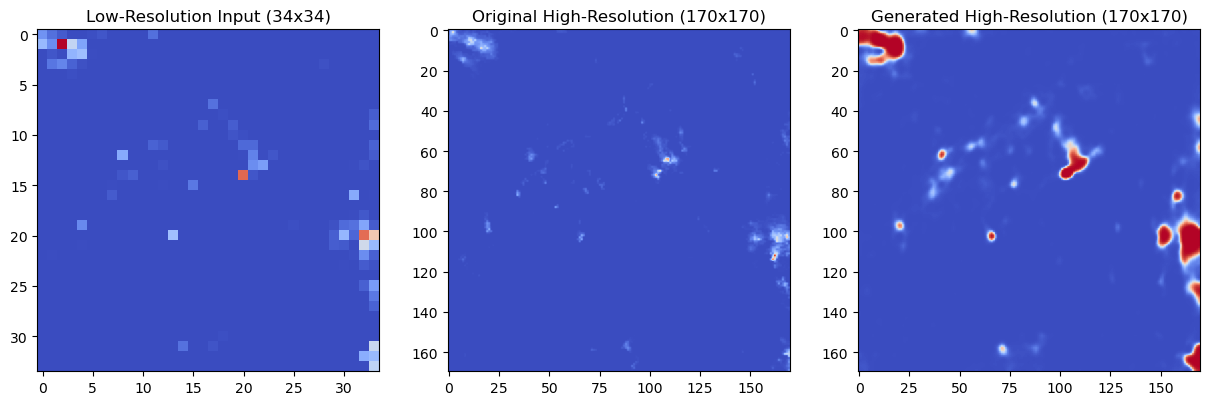

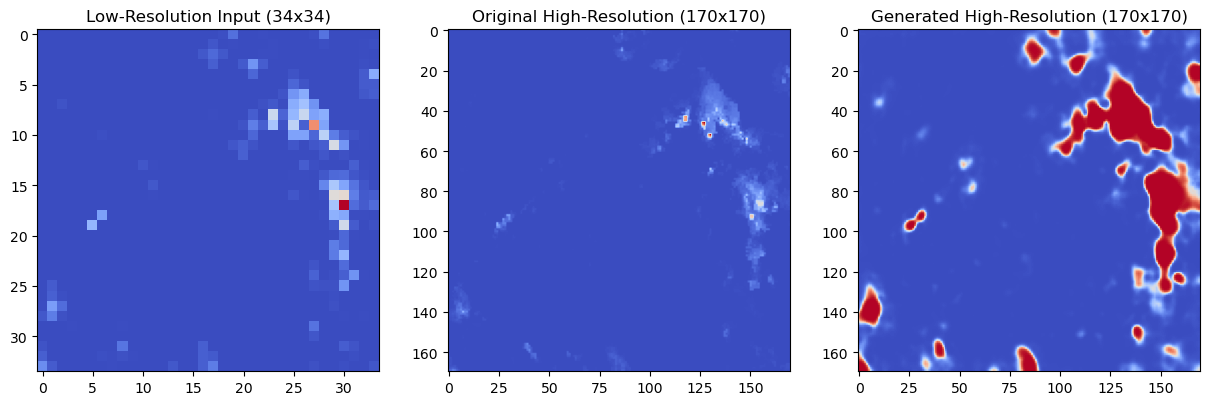

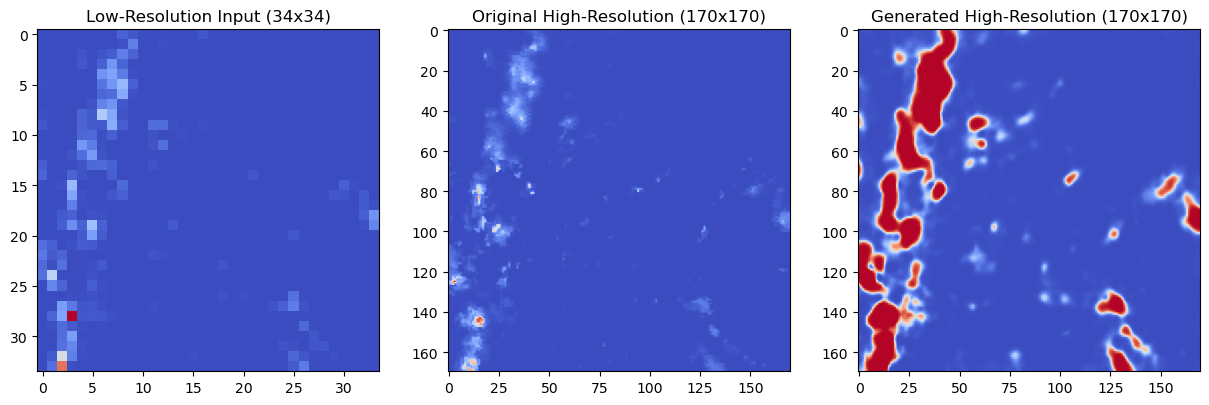

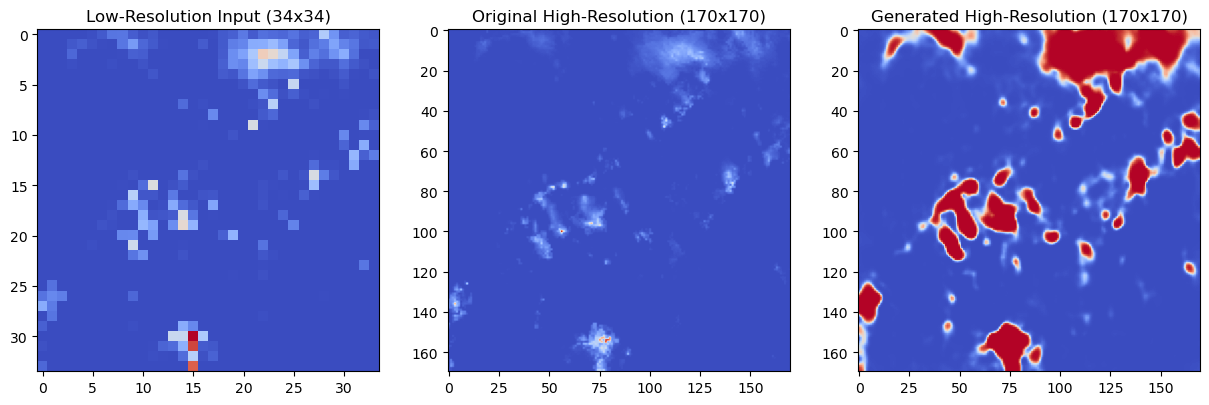

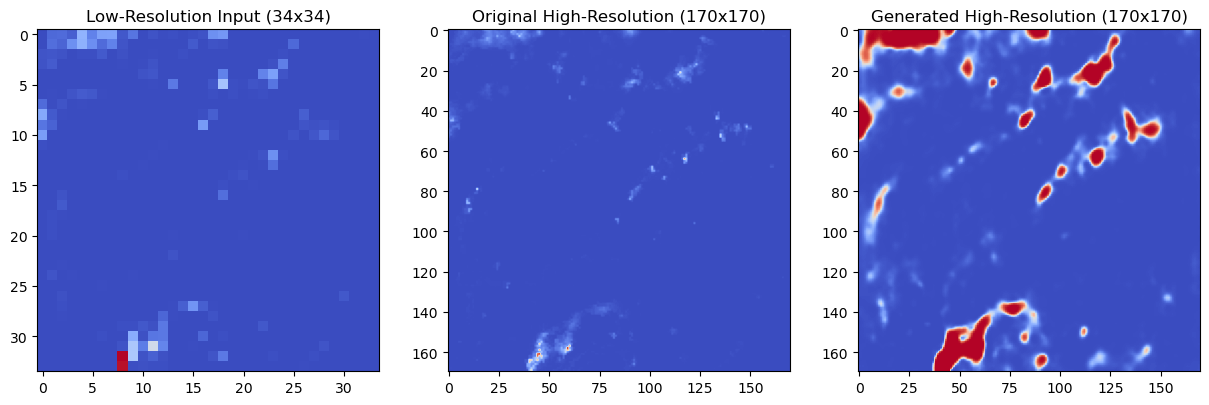

In [40]:
# Load the generator model
generator.load_state_dict(torch.load("srgan_generator_final.pth"))
generator.to(device)

# Switch to evaluation mode
generator.eval()

# Generate high-resolution images
low_res_imgs = torch.tensor(low_res_images[:5], dtype=torch.float32).unsqueeze(1).to(device)
with torch.no_grad():
    gen_hr = generator(low_res_imgs)
    gen_hr = (gen_hr + 1) / 2 

# Visualize the generated images
for i in range(5):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(low_res_imgs[i].squeeze().cpu().numpy(), cmap='coolwarm')
    plt.title('Low-Resolution Input (34x34)')

    plt.subplot(1, 3, 2)
    plt.imshow(high_res_images[i].squeeze(), cmap='coolwarm')
    plt.title('Original High-Resolution (170x170)')

    plt.subplot(1, 3, 3)
    plt.imshow(gen_hr[i].squeeze().cpu().numpy(), cmap='coolwarm')
    plt.title('Generated High-Resolution (170x170)')
    plt.show()
